## Project 4: Advanced Lane Detection

    Steps:
    
    1. Camera Calibration
    2. Distortion Correction
    3. Color and Gradient Threshold
    4. Perspective Transform
    5. Detect lane lines and curvature
    

    

## Step 1

### Calibrating the camera by using the 6*9 chessboard images and getting the camera maxtrix and camera distortion coefficients

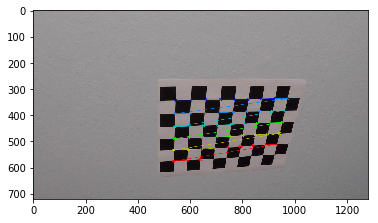

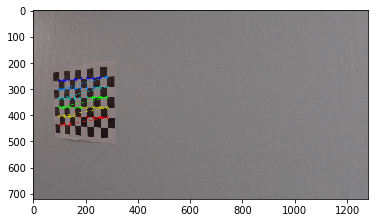

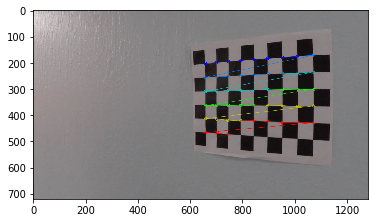

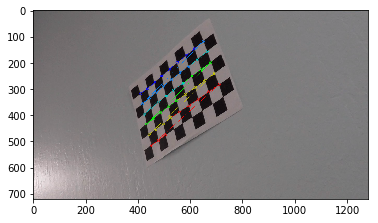

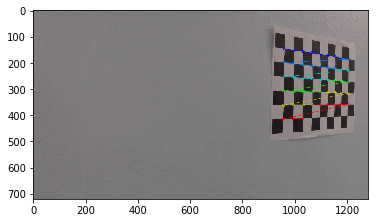

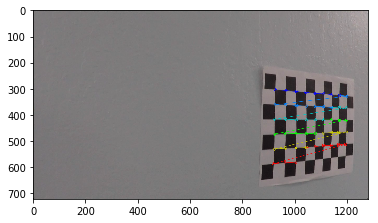

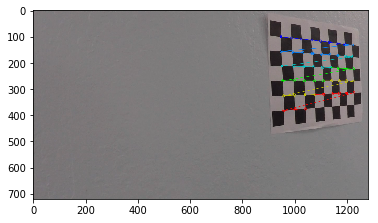

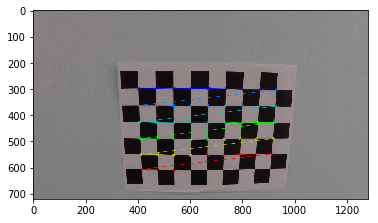

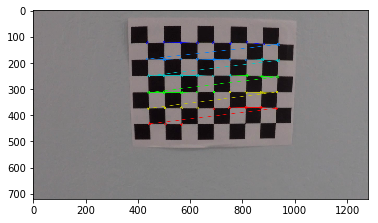

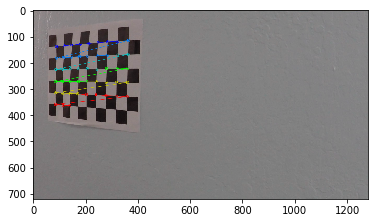

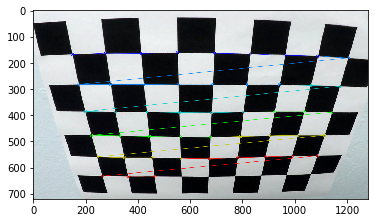

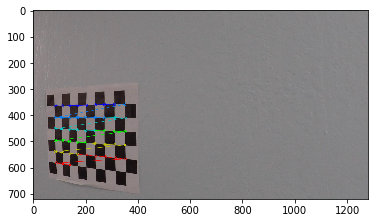

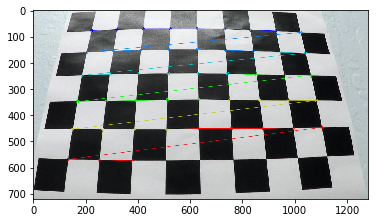

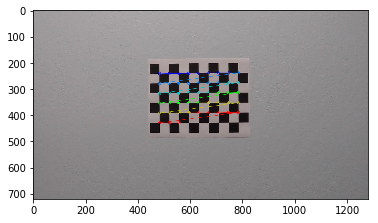

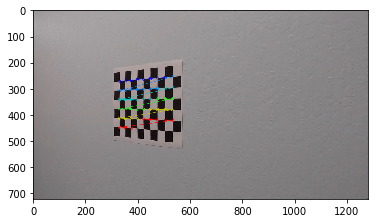

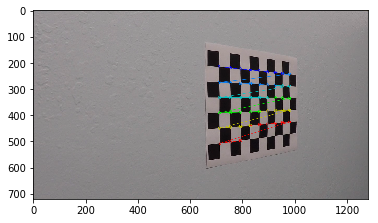

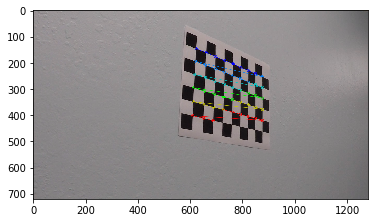

In [9]:
# Using the images from camera_cal to create a list of object points and image points

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    plt.figure()
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (8,6), corners, ret)
        #cv2.imwrite(write_name, img)
        plt.imshow(img)
        

plt.show()

In [10]:
# Calibrating camera using test image

img = cv2.imread('camera_cal/calibration1.jpg')

img_size = (img.shape[1], img.shape[0]) # getting the shape of input images[1], since the shapes are consistent

# Calibrate and obtain the camera matrix , distortion matrix, rotational and translational vectors
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

In [ ]:
# Test undistortion on a single image
img = cv2.imread('camera_cal/calibration3.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [ ]:
# Test Undistortion on all the images that were used for calibration

import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline

IMG_DST = os.path.join("camera_cal_corrected")

# Make a list of calibration images
for idx,image in  enumerate(glob.glob('camera_cal/calibration*.jpg')):
    img = mpimg.imread(image)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    print(os.path.join(IMG_DST,"calib_correct_{0}.jpg".format(idx)))
    cv2.imwrite(os.path.join(IMG_DST,"calib_correct_{0}.jpg".format(idx)), dst) 




## Step 2

### Undistorting the images based on the calibration step

In [ ]:
# Applying the undistortion on the test images

IMG_SRC = os.path.join("test_images")

# Make a list of calibration images
for image in  glob.glob(os.path.join(IMG_SRC,'*.jpg')):
    img = mpimg.imread(image)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=30)


## Step 3

### Color and Gradiant Thresholding

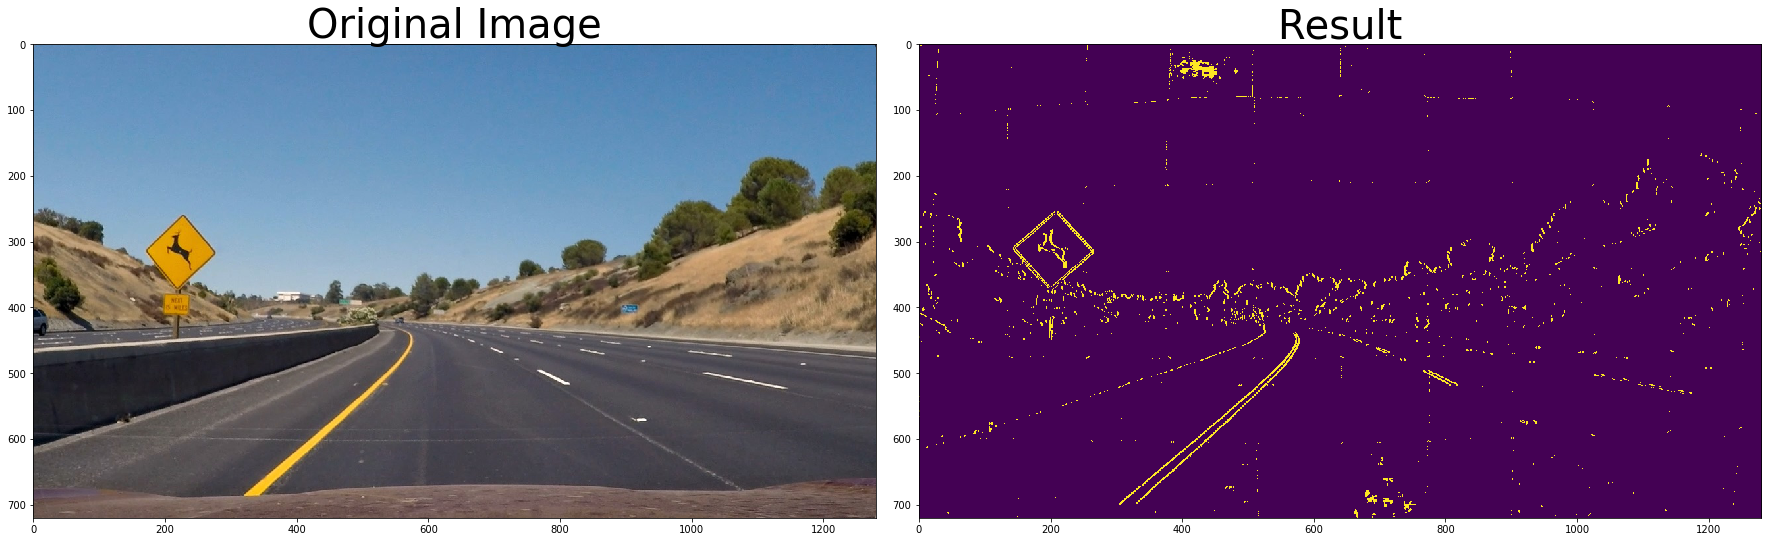

In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


image = mpimg.imread('test_images/test2.jpg')

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
   
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    if orient == 'x':
        dimg = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        dimg = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    dimg = np.absolute(dimg)
    dimg = np.uint8(255*dimg/np.max(dimg))  
    grad_binary = np.zeros_like(dimg)
    grad_binary[(dimg >= thresh[0]) & (dimg <= thresh[1])] = 1
    
    return grad_binary

def mag_thresh(image, sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F,1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F,0, 1)
    
    mimg = np.sqrt(sobelx*sobelx  + sobely*sobely)
    mimg = np.uint8(255*mimg/np.max(mimg)) 
    mag_binary = np.zeros(mimg.shape)
    mag_binary[(mimg > thresh[0]) & (mimg < thresh[1])] = 1
    
    return mag_binary

def dir_thresh(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F,1 , 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    absx = np.absolute(sobelx)
    absy = np.absolute(sobely)
    
    direction = np.arctan2(absy, absx)  
    dir_binary = np.zeros(direction.shape)  
    dir_binary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1

    return dir_binary


def hls_thresh(image, thresh=(0, 255)):
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    hls_binary = np.zeros(s_channel.shape)
    hls_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1

    return hls_binary

def combined_thresh(img):
    abs_bin = abs_sobel_thresh(img, orient='x',sobel_kernel=3, thresh=(50, 255))
    mag_bin = mag_thresh(img, sobel_kernel=3, thresh=(50, 255))
    dir_bin = dir_thresh(img, sobel_kernel=15, thresh=(0.7, 1.3))
    hls_bin = hls_thresh(img,  thresh=(170, 255))
    
    combined = np.zeros_like(hls_bin)
    combined[(abs_bin == 1) | ((mag_bin == 1) & (dir_bin == 1)) | (hls_bin == 1)] = 1

    return combined


def pipeline(img, r_thresh=(180, 255), s_thresh=(170, 255), sx_thresh=(100, 255)):
    img = np.copy(img)
    
    R = img[:,:,0]
    binary = np.zeros_like(R)
    binary[(R > r_thresh[0]) & (R <= r_thresh[1])] = 1
    
    # Convert to HLS colorshape and getting the s_channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    
    # Sobel x filter int the s_channel
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    return color_binary
    
# Undistorted Image
dimg = cv2.undistort(image, mtx, dist, None, mtx)
result = pipeline(dimg)
combined = combined_thresh(dimg)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

#result = result[int(result.shape[0]*.7):,:]

ax2.imshow(combined)
ax2.set_title('Result', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



## Step 4

### Perspective Transform

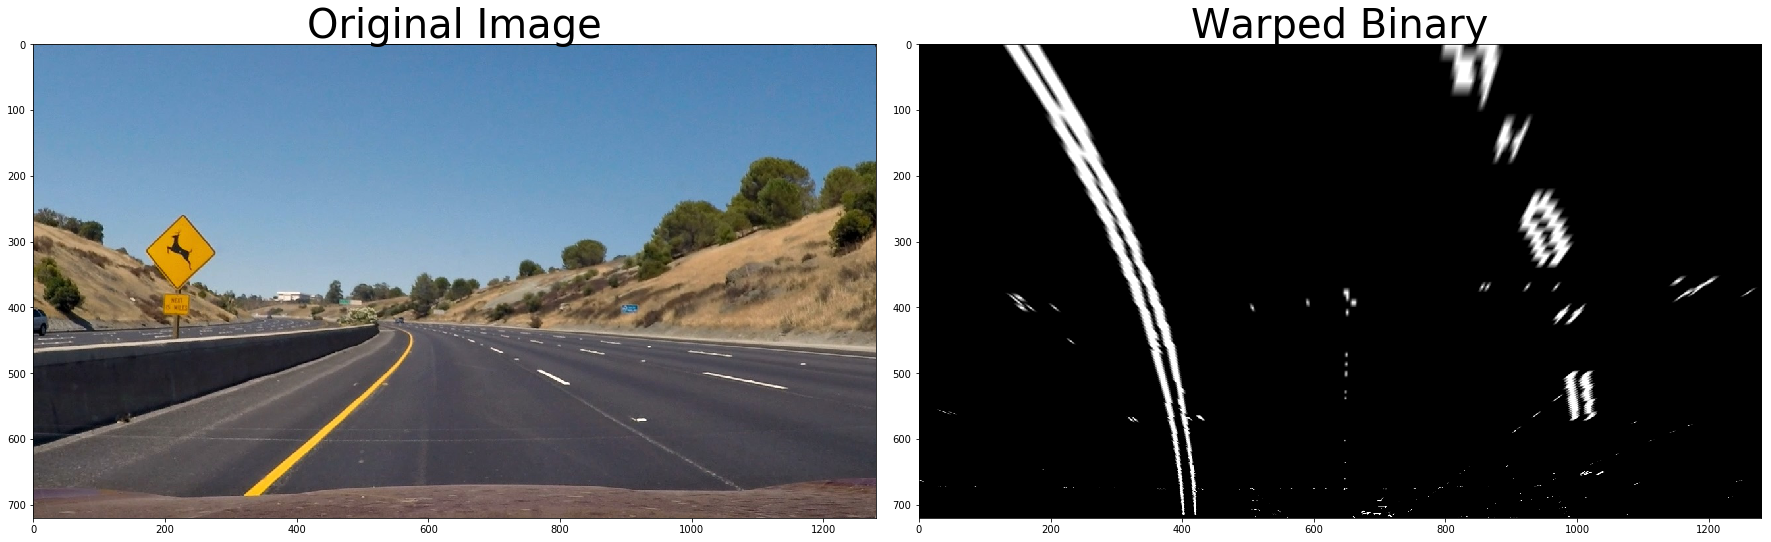

In [12]:
def perspective_transform(img):
    src_points = np.float32(
        [[200, 720],
        [1100, 720],
        [600, 450],
        [680, 450]])
    
    dst_points = np.float32(
        [[350, 720],
        [950, 720],
        [350, 0],
        [950, 0]])

    M = cv2.getPerspectiveTransform(src_points, dst_points)
    
    M_inv = cv2.getPerspectiveTransform(dst_points, src_points)

    binary_warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

    return binary_warped, M_inv

binary_warped,_ = perspective_transform(combined)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(binary_warped, cmap="gray")

ax2.set_title('Warped Binary', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [ ]:
# Generating Histogram, the peaks represent the locations the the lane

import numpy as np
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

## Step 5 

### Detecting Lane Lines and Curvature

In [13]:
from moviepy.editor import VideoFileClip

class Line():
    def __init__(self, n):

        self.n = n
        
        self.detected = False

        # Polynomial coefficients: x = A*y^2 + B*y + C
        self.current_fit = []
        
        self.recent_fits = []
        
        # Average of above
        self.best_fit = []
    
    def get_fit(self):
        return self.best_fit

    def add_fit(self, current):
    
        self.current_fit = current
        
        FULL = len(self.recent_fits) >= self.n

        # Append line fit coefficients
        self.recent_fits.append(current)
       
        if FULL:
            self.recent_fits.pop(0)

        self.best_fit = np.mean(np.array(self.recent_fits), axis=0)

        return self.best_fit


class Lane:
    
    def __init__(self, FRAMES=5, margin=100):
        
        self.is_detected = False
        
        self.margin = margin
        
        self.left_line = Line(FRAMES)
        self.right_line = Line(FRAMES)
        
        self.left_lane_inds = []
        self.right_lane_inds = []
        self.left_fit  = []
        self.right_fit = []
        self.nonzerox  = []
        self.nonzeroy  = []
        self.left_lane_inds  = []
        self.right_lane_inds = []
        
        
    def fit_lane(self, img):
        
        if self.is_detected == False:
            
            histogram = np.sum(img[img.shape[0]//2:,:], axis=0)

            out_img = np.dstack((img, img, img))*255

            midpoint = np.int(histogram.shape[0]/2)
            leftx_base = np.argmax(histogram[:midpoint])
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint

            # Choose the number of sliding windows
            nwindows = 9

            # Set height of windows
            window_height = np.int(img.shape[0]/nwindows)

            # Identify the x and y positions of all nonzero pixels in the image
            nonzero = img.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])

            # Current positions to be updated for each window
            leftx_current = leftx_base
            rightx_current = rightx_base

            # Set minimum number of pixels found to recenter window
            minpix = 50
            # Create empty lists to receive left and right lane pixel indices
            left_lane_inds = []
            right_lane_inds = []

            # Step through the windows one by one
            for window in range(nwindows):
                # Identify window boundaries in x and y (and right and left)
                win_y_low = img.shape[0] - (window+1)*window_height
                win_y_high = img.shape[0] - window*window_height
                win_xleft_low = leftx_current - self.margin
                win_xleft_high = leftx_current + self.margin
                win_xright_low = rightx_current - self.margin
                win_xright_high = rightx_current + self.margin

                # Identify the nonzero pixels in x and y within the window
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)

                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            # Concatenate the arrays of indices
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)

            # Extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds] 
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds] 

            # Fit a second order polynomial to each
            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)
            
            
            self.left_fit  = left_fit
            self.right_fit = right_fit
            self.nonzerox  = nonzerox
            self.nonzeroy  = nonzeroy
            self.left_lane_inds  = left_lane_inds
            self.right_lane_inds = right_lane_inds
            
        else:
            nonzero = img.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
         
            left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
            right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

            # Again, extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds] 
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds]
            
            # If we don't find enough relevant points, return all None (this means error)
            min_inds = 10
            if lefty.shape[0] < min_inds or righty.shape[0] < min_inds:
                self.is_detected = False
                return
            
            # Fit a second order polynomial to each
            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)
            
            # Generate x and y values for plotting
            ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
            
            self.left_fit  = left_fit
            self.right_fit = right_fit
            self.nonzerox  = nonzerox
            self.nonzeroy  = nonzeroy
            self.left_lane_inds  = left_lane_inds
            self.right_lane_inds = right_lane_inds

    def measure_curvature(self):
        """
        Calculate radius of curvature in meters
        """
        
        y_eval = 719  

        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Extract left and right line pixel positions
        leftx  = self.nonzerox[self.left_lane_inds]
        lefty  = self.nonzeroy[self.left_lane_inds]
        rightx = self.nonzerox[self.right_lane_inds]
        righty = self.nonzeroy[self.right_lane_inds]

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        
        # Calculate the new radii of curvature
        left_curve = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curve = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
        # Now our radius of curvature is in meters
        return left_curve, right_curve

    def calculate_offset(self, undist):
        """
        Calculate vehicle offset from lane center, in meters
        """
        # Calculate vehicle center offset in pixels
        bottom_y = undist.shape[0] - 1
        bottom_x_left = self.left_fit[0]*(bottom_y**2) + self.left_fit[1]*bottom_y + self.left_fit[2]
        bottom_x_right = self.right_fit[0]*(bottom_y**2) + self.right_fit[1]*bottom_y + self.right_fit[2]
        offset = undist.shape[1]/2 - (bottom_x_left + bottom_x_right)/2

        # Convert pixel offset to meters
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        offset *= xm_per_pix

        return offset

    def visualize(self, undist, m_inv, offset, left_curve, right_curve):

        # Generate x and y values for plotting
        ploty = np.linspace(0, undist.shape[0]-1, undist.shape[0])
        left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
        right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]

        color_warp = np.zeros((720, 1280, 3), dtype='uint8') 

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, m_inv, (undist.shape[1], undist.shape[0]))
        # Combine the result with the original image
        result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

        # Annotate lane curvature values and vehicle offset from center
        avg_curve = (left_curve + right_curve)/2
        label_str = 'Radius of curvature: %.1f m' % avg_curve
        result = cv2.putText(result, label_str, (30,40), 0, 1, (255, 255, 255), 2, cv2.LINE_AA)

        if offset < 0:
            label_str = 'Vehicle is %.1f m left of center' % abs(offset)
        else:
            label_str = 'Vehicle is %.1f m right of center' % abs(offset)

        result = cv2.putText(result, label_str, (30,70), 0, 1, (255, 255, 255), 2, cv2.LINE_AA)

        return result

    


In [ ]:
lane = Lane()

def process_image(img):
    # Undistort, threshold, perspective transform
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    img = combined_thresh(undist)
    binary_warped,m_inv = perspective_transform(img)
    lane.fit_lane(img)
    left_curve, right_curve = lane.measure_curvature()
    offset = lane.calculate_offset(undist)
    return lane.visualize(undist, m_inv, offset, left_curve, right_curve)

In [15]:
from IPython.display import HTML

input_video  = 'project_video.mp4'
output_video = 'output_video.mp4'

video = VideoFileClip(input_video)
video_clip = video.fl_image(process_image)
%time video_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4


100%|█████████▉| 1260/1261 [04:59<00:00,  4.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 

CPU times: user 5min 49s, sys: 3.6 s, total: 5min 53s
Wall time: 5min


In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('output_video.mp4'))

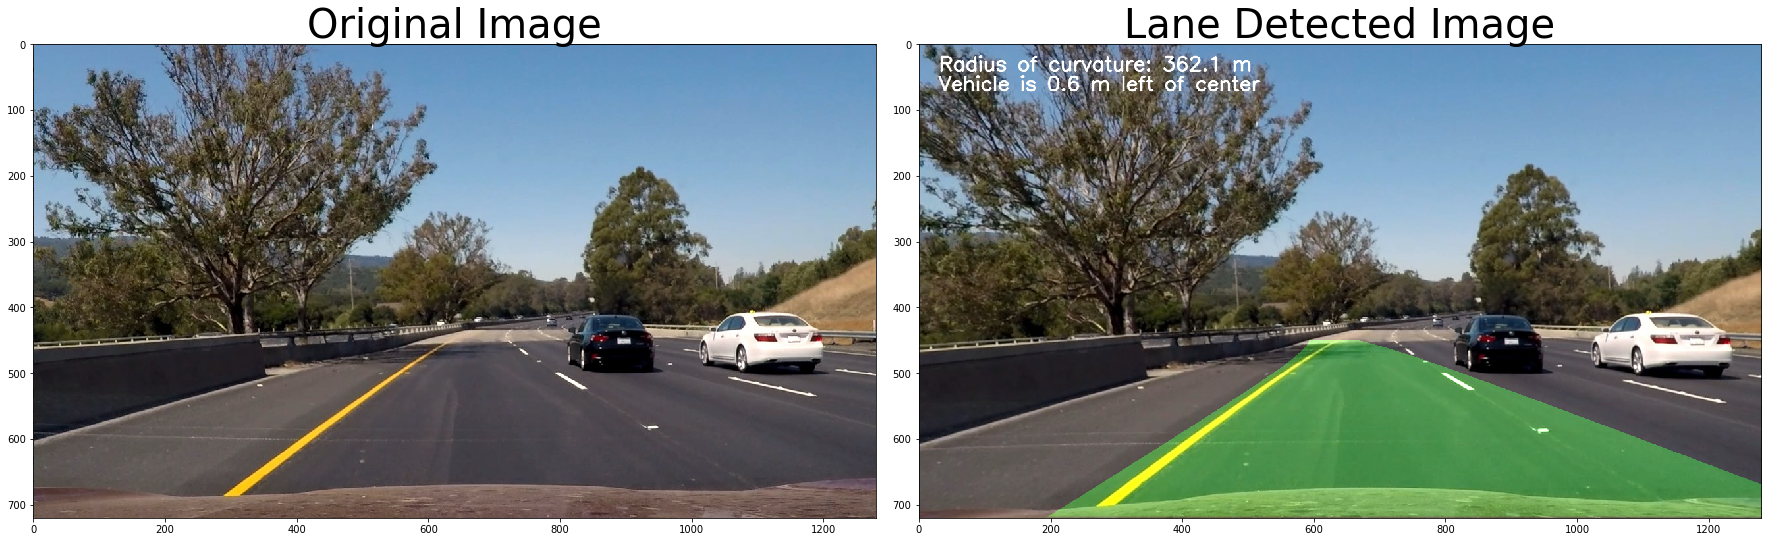

In [24]:
# Sanity Check

img_file = 'test_images/test6.jpg'
img = mpimg.imread(img_file)

result = process_image(img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Lane Detected Image', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.imshow(result)

plt.show()